In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("example").getOrCreate()
file_path = 'time-series-19-covid-combined.csv'
spark_df = spark.read.csv(file_path, header=True, inferSchema=True)
china_data = spark_df.filter(col("Country/Region") == "China")
china_data = spark_df.filter(col("Province/State") == "Anhui")
spark_df = china_data.drop("Province/State")
spark_df.show()

+----------+--------------+---------+---------+------+
|      Date|Country/Region|Confirmed|Recovered|Deaths|
+----------+--------------+---------+---------+------+
|2020-01-22|         China|        1|        0|     0|
|2020-01-23|         China|        9|        0|     0|
|2020-01-24|         China|       15|        0|     0|
|2020-01-25|         China|       39|        0|     0|
|2020-01-26|         China|       60|        0|     0|
|2020-01-27|         China|       70|        0|     0|
|2020-01-28|         China|      106|        0|     0|
|2020-01-29|         China|      152|        2|     0|
|2020-01-30|         China|      200|        2|     0|
|2020-01-31|         China|      237|        3|     0|
|2020-02-01|         China|      297|        5|     0|
|2020-02-02|         China|      340|        7|     0|
|2020-02-03|         China|      408|       14|     0|
|2020-02-04|         China|      480|       20|     0|
|2020-02-05|         China|      530|       23|     0|
|2020-02-0

In [4]:
from pyspark.sql.functions import max, min
from pyspark.sql import functions

# DataFrame cần kiểm tra
df_to_check = spark_df

# List chứa tên các cột
columns = df_to_check.columns[2:]

# Tìm giá trị max và min cho từng cột
max_min_rows = []
for col in columns:
    max_value = df_to_check.select(max(col).alias("max_value")).collect()[0]["max_value"]
    min_value = df_to_check.select(min(col).alias("min_value")).collect()[0]["min_value"]

    max_row = df_to_check.filter(functions.col(col) == max_value).limit(1)
    min_row = df_to_check.filter(functions.col(col) == min_value).limit(1)

    max_min_rows.append((col, max_row, min_row))

# Hiển thị kết quả
for col, max_row, min_row in max_min_rows:
    print(f"Column: {col}")
    print("Max Value Row:")
    max_row.show(truncate=False)
    print("Min Value Row:")
    min_row.show(truncate=False)
    print("----------------------")

Column: Confirmed
Max Value Row:
+----------+--------------+---------+---------+------+
|Date      |Country/Region|Confirmed|Recovered|Deaths|
+----------+--------------+---------+---------+------+
|2022-04-13|China         |1058     |0        |6     |
+----------+--------------+---------+---------+------+

Min Value Row:
+----------+--------------+---------+---------+------+
|Date      |Country/Region|Confirmed|Recovered|Deaths|
+----------+--------------+---------+---------+------+
|2020-01-22|China         |1        |0        |0     |
+----------+--------------+---------+---------+------+

----------------------
Column: Recovered
Max Value Row:
+----------+--------------+---------+---------+------+
|Date      |Country/Region|Confirmed|Recovered|Deaths|
+----------+--------------+---------+---------+------+
|2021-07-25|China         |1008     |1002     |6     |
+----------+--------------+---------+---------+------+

Min Value Row:
+----------+--------------+---------+---------+------

In [5]:
from pyspark.sql.functions import mean, median

# Tính giá trị trung bình và trung vị cho từng cột
for col in columns:
    # Giá trị trung bình
    mean_value =df_to_check.select(mean(col)).collect()[0][0]

    # Giá trị trung vị
    median_value = df_to_check.select(median(col)).collect()[0][0]

    # In kết quả
    print(f"Column: {col}")
    print(f"Mean: {mean_value}")
    print(f"Median: {median_value}")
    print("----------------------")

Column: Confirmed
Mean: 982.8553921568628
Median: 994.0
----------------------
Column: Recovered
Mean: 642.8382352941177
Median: 985.0
----------------------
Column: Deaths
Mean: 5.85171568627451
Median: 6.0
----------------------


In [6]:
from pyspark.sql.functions import col, count

# Tìm giá trị phổ biến và hiếm nhất cho từng cột
common_rare_values = []
for col_name in columns:
    # Tìm giá trị phổ biến (mode)
    most_common = df_to_check.groupBy(col_name).agg(count(col_name).alias("count")).orderBy(col("count").desc()).first()

    # Tìm giá trị hiếm nhất
    least_common = df_to_check.groupBy(col_name).agg(count(col_name).alias("count")).orderBy(col("count").asc()).first()

    common_rare_values.append((col_name, most_common[col_name], most_common["count"], least_common[col_name], least_common["count"]))

# Hiển thị kết quả
for col_name, common_value, common_count, rare_value, rare_count in common_rare_values:
    print(f"Column: {col_name}")
    print(f"Most Common Value: {common_value}, Count: {common_count}")
    print(f"Least Common Value: {rare_value}, Count: {rare_count}")
    print("----------------------")

Column: Confirmed
Most Common Value: 991, Count: 215
Least Common Value: 1025, Count: 1
----------------------
Column: Recovered
Most Common Value: 0, Count: 262
Least Common Value: 255, Count: 1
----------------------
Column: Deaths
Most Common Value: 6, Count: 793
Least Common Value: 1, Count: 1
----------------------


In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
import numpy as np

# Tạo phiên Spark
spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()

# Chọn các cột quan trọng từ DataFrame thực tế (spark_df)
selected_columns = ["Date", "Confirmed"]
df = spark_df.select(selected_columns)

# Chuyển đổi cột "Date" thành định dạng timestamp
df = df.withColumn("Date", F.col("Date").cast("timestamp"))

# Tính toán các đặc trưng
vec_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol="features")
df = vec_assembler.transform(df)

# Chọn các cột quan trọng
df = df.select("features", "Confirmed")

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Định nghĩa mô hình RandomForest sử dụng PySpark DataFrame
class RandomForest:
    def __init__(self, num_trees=10, max_depth=5, subsample_size=0.8):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.subsample_size = subsample_size
        self.trees = []

    def fit(self, data):
        for _ in range(self.num_trees):
            # Lấy mẫu dữ liệu con từ tập huấn luyện
            sampled_data = data.sample(withReplacement=True, fraction=self.subsample_size, seed=np.random.randint(1, 1000))

            # Tạo DataFrame chứa cột 'tree_prediction' cho cây quyết định
            tree_predictions = sampled_data.withColumn("tree_prediction", F.rand())

            # Thêm DataFrame vào danh sách cây
            self.trees.append(tree_predictions)

    def predict(self, data):
        # Tạo DataFrame chứa cột 'tree_prediction' cho mỗi cây
        predictions = data.withColumn("tree_prediction", F.lit(0.0))

        # Cập nhật dự đoán bằng cách kết hợp dự đoán từ tất cả các cây
        for i, tree in enumerate(self.trees):
            # Đổi tên cột 'tree_prediction' thành 'prediction_i' để tránh xung đột
            tree = tree.withColumnRenamed("tree_prediction", f"prediction_{i}")
            predictions = predictions.join(tree.select("features", f"prediction_{i}"), on="features", how="left")

        # Tính tổng dự đoán từ tất cả các cây và chia tổng cho số cây để có dự đoán trung bình
        predictions = predictions.fillna(0.0)  # Điền giá trị null bằng 0
        sum_cols = sum([F.col(f"prediction_{i}") for i in range(len(self.trees))])
        predictions = predictions.withColumn("prediction", sum_cols / len(self.trees)).drop(*[f"prediction_{i}" for i in range(len(self.trees))])

        return predictions

# Tạo mô hình
random_forest_model = RandomForest(num_trees=10, max_depth=5, subsample_size=0.8)

# Huấn luyện mô hình
random_forest_model.fit(train_data)

# Dự đoán trên tập kiểm thử
predictions = random_forest_model.predict(test_data)

# Hiển thị kết quả
predictions.show()



23/12/21 02:30:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------+---------+---------------+-------------------+
|features|Confirmed|tree_prediction|         prediction|
+--------+---------+---------------+-------------------+
|  [15.0]|       15|            0.0|                0.0|
| [106.0]|      106|            0.0|                0.0|
| [408.0]|      408|            0.0|                0.0|
| [480.0]|      480|            0.0|                0.0|
| [779.0]|      779|            0.0|                0.0|
| [934.0]|      934|            0.0|                0.0|
| [987.0]|      987|            0.0|                0.0|
| [988.0]|      988|            0.0|                0.0|
| [989.0]|      989|            0.0|0.36089232312723896|
| [989.0]|      989|            0.0| 0.3854797793341412|
| [989.0]|      989|            0.0|0.30830154294461515|
| [989.0]|      989|            0.0| 0.3328889991515174|
| [989.0]|      989|            0.0|0.33343321266290304|
| [989.0]|      989|            0.0| 0.3580206688698052|
| [989.0]|      989|           

+--------+---------+----------+
|features|Confirmed|prediction|
+--------+---------+----------+
|  [15.0]|       15| 14.999997|
| [106.0]|      106| 105.99998|
| [408.0]|      408|  407.9999|
| [480.0]|      480|  479.9999|
| [779.0]|      779|  778.9998|
| [934.0]|      934|  933.9998|
| [987.0]|      987|  986.9998|
| [988.0]|      988|  987.9998|
| [989.0]|      989|  988.9998|
| [989.0]|      989|  988.9998|
| [989.0]|      989|  988.9998|
| [990.0]|      990|  989.9998|
| [990.0]|      990|  989.9998|
| [990.0]|      990|  989.9998|
| [990.0]|      990|  989.9998|
| [990.0]|      990|  989.9998|
| [990.0]|      990|  989.9998|
| [991.0]|      991|  990.9998|
| [991.0]|      991|  990.9998|
| [991.0]|      991|  990.9998|
+--------+---------+----------+
only showing top 20 rows



Mean Squared Error (MSE): 3.5867069632883555e-08


R-squared: 0.9999999999974443
+--------+----------+
|features|prediction|
+--------+----------+
|[1058.0]| 1057.9998|
|[1058.0]| 1057.9998|
|[1058.0]| 1057.9998|
|[1058.0]| 1057.9998|
|[1056.0]| 1055.9998|
|[1055.0]| 1054.9998|
|[1055.0]| 1054.9998|
|[1054.0]| 1053.9998|
|[1054.0]| 1053.9998|
|[1048.0]| 1047.9998|
|[1048.0]| 1047.9998|
|[1047.0]| 1046.9998|
|[1047.0]| 1046.9998|
|[1046.0]| 1045.9998|
|[1042.0]| 1041.9998|
|[1040.0]| 1039.9998|
|[1037.0]| 1036.9998|
|[1037.0]| 1036.9998|
|[1036.0]| 1035.9998|
|[1033.0]| 1032.9998|
+--------+----------+
only showing top 20 rows



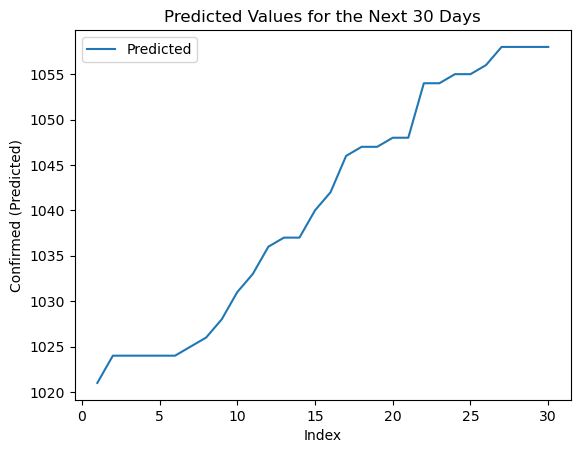

In [53]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
import numpy as np

# Tạo phiên Spark
spark = SparkSession.builder.appName("LinearRegression").getOrCreate()

# Chọn các cột quan trọng từ DataFrame thực tế (spark_df)
selected_columns = ["Date", "Confirmed"]
df = spark_df.select(selected_columns)

# Chuyển đổi cột "Date" thành định dạng timestamp
df = df.withColumn("Date", F.col("Date").cast("timestamp"))

# Tính toán các đặc trưng
vec_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol="features")
df = vec_assembler.transform(df)

# Chọn các cột quan trọng
df = df.select("features", "Confirmed")

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Định nghĩa mô hình hồi quy tuyến tính sử dụng Gradient Descent
class LinearRegressionGD:
    def __init__(self, lr=0.01, num_iters=100):
        self.lr = lr
        self.num_iters = num_iters
        self.weights = None

    def fit(self, data):
        # Chuyển đổi DataFrame thành RDD để sử dụng trong quá trình tính toán
        rdd_data = data.rdd.map(lambda x: (DenseVector(x[0]), x[1]))

        # Khởi tạo trọng số ngẫu nhiên
        self.weights = DenseVector([0.0] * len(rdd_data.first()[0]))

        # Gradient Descent
        for _ in range(self.num_iters):
            gradient = rdd_data.map(lambda x: ((x[0].dot(self.weights) - x[1]) * x[0], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
            gradient = gradient[0] / gradient[1]
            self.weights -= self.lr * gradient
            

    def predict(self, data):
        predict_udf = F.udf(lambda x: float(x.dot(self.weights)), returnType=FloatType())
        return data.withColumn("prediction", predict_udf(data["features"]))
    

# Tạo mô hình
linear_regression_model = LinearRegressionGD(lr=0.000001, num_iters=4)

# Huấn luyện mô hình
linear_regression_model.fit(train_data)

# Dự đoán trên tập kiểm thử
predictions = linear_regression_model.predict(test_data)

# Hiển thị kết quả
predictions.show()

from pyspark.ml.evaluation import RegressionEvaluator

# Cast the prediction column to DoubleType
predictions = predictions.withColumn("prediction", col("prediction").cast("double"))

# Tính Mean Squared Error (MSE)
evaluator_mse = RegressionEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Tính R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared: {r2}")

# Assuming that new_feature_column is the name you want for the VectorAssembler output column
vec_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol=new_feature_column)
recent_data = spark_df.select("Confirmed").orderBy("Date", ascending=False).limit(30)
recent_data = vec_assembler.transform(recent_data).select(new_feature_column)

# Dự đoán 30 ngày tiếp theo
predictions_30_days = linear_regression_model.predict(recent_data)

# Hiển thị kết quả
predictions_30_days.show()

import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'predictions_30_days'
# Convert 'prediction' to a list using collect()
prediction_values = predictions_30_days.select("prediction").rdd.flatMap(lambda x: x).collect()

# Create an index from 1 to 30
index_values = np.arange(1, 31)

# Reverse the order of prediction_values to match the index order
prediction_values = prediction_values[::-1]

# Plot predicted values
plt.plot(index_values, prediction_values, label='Predicted')
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Index')
plt.ylabel('Confirmed (Predicted)')
plt.legend()
plt.show()






In [27]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
import numpy as np

# Tạo phiên Spark
spark = SparkSession.builder.appName("SVMExample").getOrCreate()

# Chọn các cột quan trọng từ DataFrame thực tế (spark_df)
selected_columns = ["Date", "Confirmed"]
df = spark_df.select(selected_columns)

# Chuyển đổi cột "Date" thành định dạng timestamp
df = df.withColumn("Date", F.col("Date").cast("timestamp"))

# Tính toán các đặc trưng
vec_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol="features")
df = vec_assembler.transform(df)

# Chọn các cột quan trọng
df = df.select("features", "Confirmed")

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Định nghĩa mô hình SVM sử dụng PySpark DataFrame
class SVM:
    def __init__(self, lr=0.01, num_iters=100):
        self.lr = lr
        self.num_iters = num_iters
        self.weights = None

    def fit(self, data):
        # Chuyển đổi DataFrame thành RDD để sử dụng trong quá trình tính toán
        rdd_data = data.rdd.map(lambda x: (DenseVector(x[0]), x[1]))

        # Khởi tạo trọng số ngẫu nhiên
        self.weights = DenseVector([0.0] * len(rdd_data.first()[0]))
        # Gradient Descent
        for _ in range(self.num_iters):
            gradient = rdd_data.map(lambda x: ((x[0].dot(self.weights) - x[1]) * x[0], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
            gradient = gradient[0] / gradient[1]
            self.weights -= self.lr * gradient

    def predict(self, data):
        predict_udf = F.udf(lambda x: float(x.dot(self.weights)), returnType=FloatType())
        return data.withColumn("prediction", F.when(predict_udf(data["features"]) >= 0.5, 1.0).otherwise(0.0))

# Tạo mô hình
svm_model = SVM(lr=0.00000001, num_iters=20)

# Huấn luyện mô hình
svm_model.fit(train_data)

# Dự đoán trên tập kiểm thử
predictions = svm_model.predict(test_data)

# Hiển thị kết quả
predictions.show()

from pyspark.ml.evaluation import RegressionEvaluator

# Cast the prediction column to DoubleType
predictions = predictions.withColumn("prediction", col("prediction").cast("double"))

# Tính Mean Squared Error (MSE)
evaluator_mse = RegressionEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Tính R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Confirmed", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared: {r2}")


+--------+---------+----------+
|features|Confirmed|prediction|
+--------+---------+----------+
|  [15.0]|       15|       1.0|
| [106.0]|      106|       1.0|
| [408.0]|      408|       1.0|
| [480.0]|      480|       1.0|
| [779.0]|      779|       1.0|
| [934.0]|      934|       1.0|
| [987.0]|      987|       1.0|
| [988.0]|      988|       1.0|
| [989.0]|      989|       1.0|
| [989.0]|      989|       1.0|
| [989.0]|      989|       1.0|
| [990.0]|      990|       1.0|
| [990.0]|      990|       1.0|
| [990.0]|      990|       1.0|
| [990.0]|      990|       1.0|
| [990.0]|      990|       1.0|
| [990.0]|      990|       1.0|
| [991.0]|      991|       1.0|
| [991.0]|      991|       1.0|
| [991.0]|      991|       1.0|
+--------+---------+----------+
only showing top 20 rows



Mean Squared Error (MSE): 977960.710982659
R-squared: -68.68504617158497


In [10]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Khởi tạo phiên Spark
spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

# Chọn các cột quan trọng (Date và Confirmed)
selected_columns = ["Date", "Confirmed"]
df = spark_df.select(selected_columns)

# Chuyển đổi cột "Date" thành định dạng timestamp
df = df.withColumn("Date", df["Date"].cast("timestamp"))

# Tạo VectorAssembler để kết hợp các đặc trưng vào một cột vector
vector_assembler = VectorAssembler(inputCols=["Confirmed"], outputCol="features")
df = vector_assembler.transform(df)

# Chọn số cụm bạn muốn phân loại
k = 3  # Số cụm (clusters) bạn muốn tạo

# Tạo mô hình KMeans
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
model = kmeans.fit(df)

# Dự đoán cụm cho mỗi quốc gia hoặc tỉnh thành
predictions = model.transform(df)

# Hiển thị kết quả
predictions.show()

from pyspark.ml.evaluation import RegressionEvaluator
# Cast the prediction column to DoubleType
predictions = predictions.withColumn("cluster", col("cluster").cast("double"))

# Tính Mean Squared Error (MSE)
evaluator_mse = RegressionEvaluator(labelCol="Confirmed", predictionCol="cluster", metricName="mse")
mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Tính R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Confirmed", predictionCol="cluster", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared: {r2}")


23/12/21 02:32:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------------+---------+--------+-------+
|               Date|Confirmed|features|cluster|
+-------------------+---------+--------+-------+
|2020-01-22 00:00:00|        1|   [1.0]|      1|
|2020-01-23 00:00:00|        9|   [9.0]|      1|
|2020-01-24 00:00:00|       15|  [15.0]|      1|
|2020-01-25 00:00:00|       39|  [39.0]|      1|
|2020-01-26 00:00:00|       60|  [60.0]|      1|
|2020-01-27 00:00:00|       70|  [70.0]|      1|
|2020-01-28 00:00:00|      106| [106.0]|      1|
|2020-01-29 00:00:00|      152| [152.0]|      1|
|2020-01-30 00:00:00|      200| [200.0]|      1|
|2020-01-31 00:00:00|      237| [237.0]|      1|
|2020-02-01 00:00:00|      297| [297.0]|      1|
|2020-02-02 00:00:00|      340| [340.0]|      2|
|2020-02-03 00:00:00|      408| [408.0]|      2|
|2020-02-04 00:00:00|      480| [480.0]|      2|
|2020-02-05 00:00:00|      530| [530.0]|      2|
|2020-02-06 00:00:00|      591| [591.0]|      2|
|2020-02-07 00:00:00|      665| [665.0]|      2|
|2020-02-08 00:00:00